通过神经网络预测每天自行车的租客人数


In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

加载数据
附件中的数据集从 2011 年 1 月 1 日到 2012 年 12 月 31 日期间每天每小时的骑车人数。
骑车用户分成临时用户和注册用户，cnt 列是骑车用户数汇总列
instant : 索引
dteday : 日期
season : 季度，1 2 3 4
yr : 年  （第几年）
mnth  : 月份
hr: 小时段
holiday : 是否是假日
weekday : 周几
workingday ： 是否工作日
weathersit : 天气
windspeed ：风速
cnt ： 改天该小时段的用车数  （向后推一个小时）也是要预测的值

In [8]:
data_path = 'hour.csv'
rides_df = pd.read_csv(data_path, sep = ',')

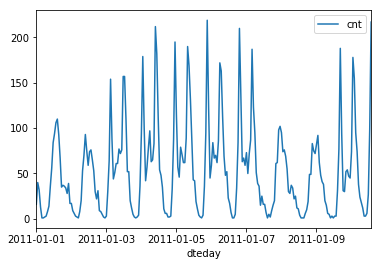

In [9]:
rides_df[: 24*10].plot(x = 'dteday', y = 'cnt')

In [10]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for each in dummy_fields:
    dummies = pd.get_dummies(rides_df[each], prefix=each, drop_first=False)
    rides = pd.concat([rides_df, dummies], axis = 1)
    
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                 'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides_df.drop(fields_to_drop, axis =1)

数据归一化，保存换算因子，在网络预测时还原数据

In [46]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

test_data用以验证网络的泛化能力，即预测数据的能力
data是除test_data以外的数据，用来训练网络

In [47]:
test_data = data[-21*24:]

data = data[:-21*24]

# 预测的目标量
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis = 1), data[target_fields]

test_features, test_targets = test_data.drop(target_fields, axis =1), test_data[target_fields]

训练网络的数据集拆分成两个数据集，一个用作训练，一个用在网络训练完成后验证网络
根据验证集测试结果来进行网路结构的调整
之所以再分一个test_data,是为了防止在调整网络结构的过程中使网络记住验证数据集，从而高估了网络的泛化能力

In [48]:
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

构建网络结构
前向传播与误差反馈部分

In [49]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes,output_nodes,learing_rate ):
        #初始话化输入、隐藏、输出结点
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodez = output_nodes
        
        #初始化权重
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5,
                                                       (input_nodes, hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5,
                                                        (hidden_nodes,output_nodes))
        
        self.lr = learning_rate
        
        #激活函数
        self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        
        
    def train(self, features, targets):
        
        n_records = features.shape[0]
        #初始化每步的权重改变量
        delta_weight_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weight_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        for X, y in zip(features, targets):
            #计算隐藏层的输入输出
            hidden_inputs = np.dot(X, self.weights_input_to_hidden)
            hidden_outputs = self.activation_function(hidden_inputs)
            
            #计算输出层的输入和输出
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
            final_outputs = final_inputs
            
            #####反向传播
            error = y - final_outputs
            
            hidden_error = np.dot(error, self.weights_hidden_to_output.T)
            
            #误差项需要乘以激活函数的梯度
            output_error_term = error * 1
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
            
            
            delta_weight_i_h += hidden_error_term * X[:, None]
            delta_weight_h_o += output_error_term * hidden_outputs[:, None]
            
        self.weights_hidden_to_output +=  self.lr * delta_weight_h_o / n_records
        self.weights_input_to_hidden +=  self.lr * delta_weight_i_h / n_records   
        
    def run(self, features):
        
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) 
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = final_inputs 
        
        return final_outputs
            
                      

In [44]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.隐藏层激活函数
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]   #样本数据量
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs =  np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ### 

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            error_term = error * 1   #误差项需要乘以激活函数的梯度
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(error_term, self.weights_hidden_to_output.T)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term = error * 1
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
            #print(output_error_term.shape)
            #print(hidden_outputs.shape)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]
            #print(delta_weights_h_o.shape)
            

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output +=  self.lr * delta_weights_h_o / n_records# update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden +=  self.lr * delta_weights_i_h / n_records# update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)  # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [14]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [50]:
import sys

### Set the hyperparameters here ###
iterations = 3000
learning_rate = 0.2
hidden_nodes = 7
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # 随机选择128个记录为一组进行训练
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                          
    network.train(X, y)
    
#     print (network.run(train_features))
#     print (train_targets['cnt'].values)
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 0.5% ... Training loss: 0.753 ... Validation loss: 1.605

E:\Anaconda3\envs\dlnd\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


Progress: 100.0% ... Training loss: 0.610 ... Validation loss: 1.340

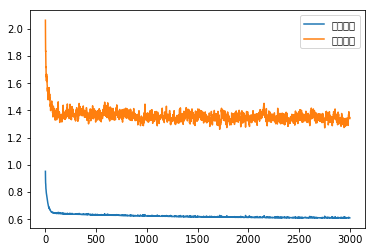

In [51]:
plt.plot(losses['train'], label='训练误差')
plt.plot(losses['validation'], label='验证误差')
plt.legend()
_ = plt.ylim()

E:\Anaconda3\envs\dlnd\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


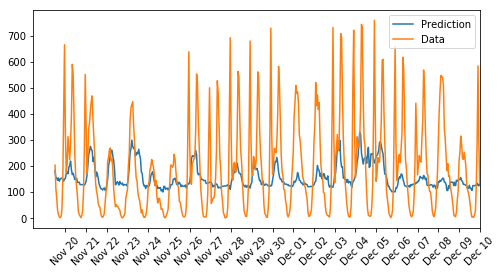

In [52]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)